shape of val_set[0] (1000, 784)
shape of val_set[1] (1000, 784)
(784, 10665)
(784, 2000)
(784, 2115)


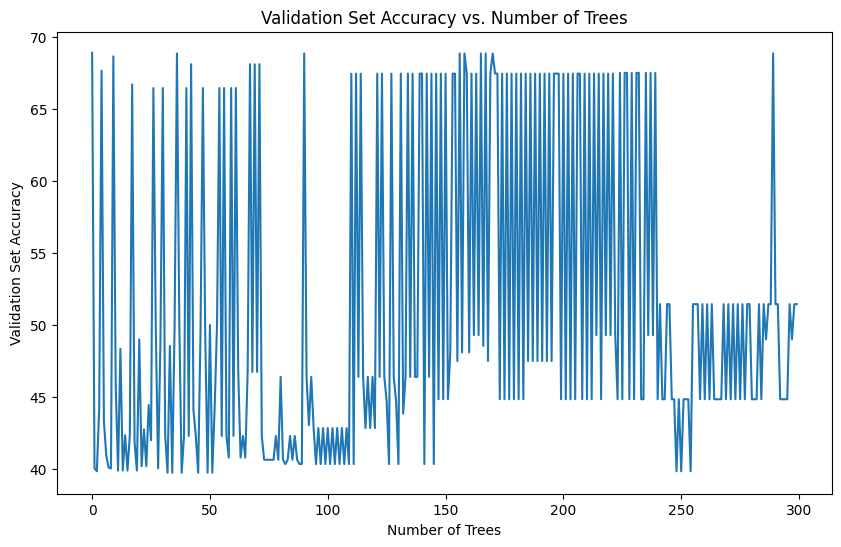

Max accuracy of val set: 68.85 at stump: 34 with alpha: 0.08986400677193057
Test accuracy: 53.664302600472816


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

class mnistPCA:
    def __init__(self, class_matrix, count):
        self.class_matrix = class_matrix
        self.count = count

        # making the data matrix
        self.X = []
        for i in range(len(self.class_matrix)):
            for j in range(count[i]):
                self.X.append(self.class_matrix[i][j])
        self.X = np.array(self.X)
        self.X = self.X.T


        self.X_mean = np.mean(self.X, axis=1).reshape(784, 1)

        # remove mean from the data
        self.X = self.X - self.X_mean
        print(self.X.shape)

        # use PCA on centralised data
        self.cov_X = np.dot(self.X, self.X.T) / sum(count) - 1

        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.cov_X)
        self.eigen_values = np.real(self.eigen_values)
        self.eigen_vectors = np.real(self.eigen_vectors)

        # sort the eigen values in descending order, and eigen vectors accordingly
        idx = self.eigen_values.argsort()[::-1]
        self.eigen_values = self.eigen_values[idx]
        self.eigen_vectors = self.eigen_vectors[:, idx]

        # making the U matrix
        self.U = []
        for i in range(len(self.eigen_values)):
            self.U.append(self.eigen_vectors[:, :i+1])

    def reduceDim(self, eigen):
        U_p = self.U[eigen - 1]

        # Y = U_p.T * X
        Y = np.dot(U_p.T, self.X)

        Y_label = np.zeros(sum(self.count), dtype=int)

        for i in range(len(self.class_matrix)):
            for j in range(self.count[i]):
                Y_label[sum(self.count[:i]) + j] = i

        return Y, Y_label

class DecisionStump:
    def __init__(self, data, labels, weights):
        self.data = data
        self.labels = labels
        self.weights = weights

        self.error, self.feature, self.threshold, self.alpha, self.new_data, self.new_labels, self.new_weigths = self.fit()

        left = []
        right = []
        for j in range(self.data.shape[1]):
            if self.data[self.feature][j] < self.threshold:
                left.append(self.labels[j])
            else:
                right.append(self.labels[j])

        left_probab = [0, 0]
        right_probab = [0, 0]

        # print("left:", left)
        # print("right:", right)

        for j in range(len(left)):
            if left[j] == -1:
                left_probab[0] += 1
            elif left[j] == 1:
                left_probab[1] += 1

        for j in range(len(right)):
            if right[j] == -1:
                right_probab[0] += 1
            elif right[j] == 1:
                right_probab[1] += 1

        self.left_probab = left_probab
        self.right_probab = right_probab

        # print("left probab:", left_probab)
        # print("right probab:", right_probab)

    def fit(self):
        best_error = 1
        best_feature = -1
        best_threshold = -1

        for i in range(self.data.shape[0]):
            d_copy = np.unique(self.data[i])
            means = (d_copy[:-1] + d_copy[1:]) / 2

            for mean in means:
                y_pred = np.where(self.data[i] < mean, -1, 1)
                error = np.sum((y_pred != self.labels) * self.weights)

                if error < best_error:
                    best_error = error
                    best_feature = i
                    best_threshold = mean

        alpha = 0.5 * np.log(((1 - best_error) / (best_error + 1e-6)))
        weights = self.weights * np.exp(-alpha * self.labels * np.where(self.data[best_feature] < best_threshold, -1, 1))
        weights /= np.sum(weights)

        data_T = self.data.T

        new_data = []
        new_labels = []

        cum_weights = np.cumsum(weights)
        for i in range(len(weights)):
            random = np.random.rand()
            for j in range(1, len(weights)):
                if random < cum_weights[j] and random >= cum_weights[j-1]:
                    new_data.append(data_T[j])
                    new_labels.append(self.labels[j])
                    break

        new_data = np.array(new_data)
        # print("old data:", self.data.shape)
        # print("new data:", new_data.shape)
        new_data = new_data.T
        new_labels = np.array(new_labels)
        # print("old labels:", self.labels.shape)
        # print("new labels:", new_labels.shape)

        new_weights = np.ones(len(new_labels)) / len(new_labels)

        return best_error, best_feature, best_threshold, alpha, new_data, new_labels, new_weights

    def predict(self, data, labels):
        accurate = 0
        for i in range(data.shape[1]):
            if data[self.feature][i] < self.threshold:
                if labels[i] == -1:
                    accurate += 1
            else:
                if labels[i] == 1:
                    accurate += 1

        return (accurate / data.shape[1]) * 100

## Compute error rate, alpha and w
# def compute_error(y, y_pred, w_i):
#     return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

# def compute_alpha(error):
#     return np.log((1 - error) / error)

# def update_weights(w_i, alpha, y, y_pred):
#     return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

# class AdaBoost:
#     def __init__(self, n_estimators=300):
#         self.n_estimators = n_estimators
#         self.estimators = []
#         self.alphas = []
#         self.val_accuracies = []

#     def fit(self):
#         best_error = 1
#         best_feature = -1
#         best_threshold = -1

#         for i in range(self.data.shape[0]):
#             dim_copy = np.unique(self.data[i])
#             means = (dim_copy[:-1] + dim_copy[1:]) / 2

#             for mean in means:
#                 y_pred = np.where(self.data[i] < mean, -1, 1)
#                 error = np.sum((y_pred != self.labels) * self.weights)

#                 if error < best_error:
#                     best_error = error
#                     best_feature = i
#                     best_threshold = mean

#         alpha = 0.5 * np.log(((1 - best_error) / (best_error + 1e-6)))
#         weights = self.weights * np.exp(-alpha * self.labels * np.where(self.data[best_feature] < best_threshold, -1, 1))
#         # weights = np.zeros(len(self.weights))
#         # for i in range(len(self.weights)):
#         #     if self.labels[i] == best_y_pred[i]:
#         #         weights[i] = self.weights[i] * np.exp(-alpha)
#         #     else:
#         #         weights[i] = self.weights[i] * np.exp(alpha)

#         # weights = self.weights * np.exp(np.where(self.data[best_feature] < best_threshold, -alpha, alpha))
#         weights /= np.sum(weights)

#         # return the new data set with normalised weights
#         data_T = self.data.T

#         new_data = []
#         new_labels = []

#         cumul_weights = np.cumsum(weights)
#         for i in range(len(weights)):
#             rand = np.random.rand()
#             for j in range(1, len(weights)):
#                 if rand < cumul_weights[j] and rand >= cumul_weights[j-1]:
#                     new_data.append(data_T[j])
#                     new_labels.append(self.labels[j])
#                     break

#         new_data = np.array(new_data)
#         # print(self.data.shape)
#         # print(new_data.shape)
#         new_data = new_data.T
#         new_labels = np.array(new_labels)
#         # print(self.labels.shape)
#         # print(new_labels.shape)

#         new_weights = np.ones(len(new_labels)) / len(new_labels)

#         return best_error, best_feature, best_threshold, alpha, new_data, new_labels, new_weights

#     def predict(self, X):
#         predictions = np.zeros(X.shape[0])
#         for stump, alpha in zip(self.estimators, self.alphas):
#             predictions += alpha * stump.predict(X)
#         return np.sign(predictions)

#     def evaluate_test_set(self, X_test, y_test):
#         test_predictions = self.predict(X_test)
#         test_accuracy = np.mean(test_predictions == y_test)
#         print("Test Set Accuracy:", test_accuracy)
#         return test_accuracy

def main():
    # data = np.load('mnist.npz')
    data = np.load(tf.keras.utils.get_file('mnist.npz', 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'))

    train = data['x_train']
    train_label = data['y_train']
    test = data['x_test']
    test_label = data['y_test']

    train = train.reshape(len(train), 784)
    test = test.reshape(len(test), 784)

    # preprocessing the data
    class_matrix = []
    count = np.zeros(2, dtype=int)

    for i in range(2):
        vector = []
        for j in range(len(train)):
            count[i] += 1 if train_label[j] == i else 0
            if train_label[j] == i:
                vector.append(train[j])
        class_matrix.append(vector)

    for i in range(2):
        class_matrix[i] = np.array(class_matrix[i])
    count = np.array(count)

    test_matrix = []
    count_test = np.zeros(2, dtype=int)

    for i in range(2):
        vector = []
        for j in range(len(test)):
            count_test[i] += 1 if test_label[j] == i else 0
            if test_label[j] == i:
                vector.append(test[j])
        test_matrix.append(vector)

    for i in range(2):
        test_matrix[i] = np.array(test_matrix[i])
    count_test = np.array(count_test)

    val_set = []
    for i in range(2):
        vector = []
        for j in range(1000):
            vector.append(class_matrix[i][j])
            class_matrix[i] = np.delete(class_matrix[i], j, axis=0)
        vector = np.array(vector)
        val_set.append(vector)
        count[i] -= 1000

    print("shape of val_set[0]", val_set[0].shape)
    print("shape of val_set[1]", val_set[1].shape)

    test_label = np.zeros(sum(count_test), dtype=int)
    for i in range(2):
        if i == 0:
            for j in range(count_test[i]):
                test_label[j] = -1
        else:
            for j in range(count_test[i]):
                test_label[sum(count_test[:i]) + j] = 1

    pca = mnistPCA(class_matrix, count)
    Y, Y_label = pca.reduceDim(5)

    pca_val = mnistPCA(val_set, np.array([1000, 1000]))
    val_pca, val_label = pca_val.reduceDim(5)

    pca_test = mnistPCA(test_matrix, count_test)
    test_pca, test_label = pca_test.reduceDim(5)

    for i in range(2):
        if i == 0:
            for j in range(count[i]):
                Y_label[j] = -1
        else:
            for j in range(count[i]):
                Y_label[sum(count[:i]) + j] = 1

    for i in range(2):
        if i == 0:
            for j in range(1000):
                val_label[j] = -1
        else:
            for j in range(1000):
                val_label[1000 + j] = 1

    # print(Y.shape)
    # print(Y_label.shape)

    # print(val_pca.shape)
    # print(val_label.shape)
# ---------------------------------------------------------------------------------------------------------------

    # implement adaboost
    Y_weigths = np.ones(sum(count)) / sum(count)

    stumps = []
    stump_accuracy = []
    stump_alpha = []
    init_stump = DecisionStump(Y, Y_label, Y_weigths)

    stumps.append(init_stump)
    stump_accuracy.append(init_stump.predict(val_pca, val_label))
    stump_alpha.append(init_stump.alpha)

    for i in range(1, 300):
        # print(i+1, end=' ')
        stump = DecisionStump(stumps[i-1].new_data, stumps[i-1].new_labels, stumps[i-1].new_weigths)
        stumps.append(stump)
        stump_accuracy.append(stump.predict(val_pca, val_label))
        stump_alpha.append(stump.alpha)

        if stump_alpha[i] == stump_alpha[i-1] and stump_accuracy[i] == stump_accuracy[i-1] and stumps[i].feature == stumps[i-1].feature and stumps[i].threshold == stumps[i-1].threshold and stumps[i].error == stumps[i-1].error:
            break
        # print(stump_accuracy[i])

    # plot the accuracy of the stumps
    plt.figure(figsize=(10, 6))
    plt.plot(stump_accuracy)
    plt.xlabel('Number of Trees')
    plt.ylabel('Validation Set Accuracy')
    plt.title('Validation Set Accuracy vs. Number of Trees')
    plt.show()

    # find the highest accuracy stump with index
    max_accuracy = max(stump_accuracy[2:])
    max_accuracy_index = stump_accuracy[2:].index(max_accuracy)

    print('Max accuracy of val set:', max_accuracy, 'at stump:', max_accuracy_index, 'with alpha:', stump_alpha[max_accuracy_index])
    print("Test accuracy:", stumps[max_accuracy_index].predict(test_pca, test_label), "%")

if __name__ == "__main__":
    main()